## Final summary

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import lbl2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import folium
import matplotlib
from pyspark.sql.functions import date_format
from pyspark.sql import SparkSession, functions as F
import seaborn as sns

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZon", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

### ETL

- The following ETL script downloads the external SA2 datasets and the covid 
data using URLs and then cleans and preprocesses them.
- Next, the script cleans and preprocesses the internal dataset and then merges
it with the external dataset.
- The script prepares a final dataset which is further used throughout the 
analysis to build a ranking model for the merchants.

In [3]:
%run "../scripts/ETL.py" '../scripts/paths.json'

### Outlier Analysis

The following dataset is the full internal + external dataset merged together. 

In [4]:
# Show the first five rows of the complete dataset
final_join3.limit(5)

22/10/07 09:31:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,postcodes,int_sa2,SA2_code,SA2_name,income_2018-2019,total_males,total_females,total_persons,state_code,state_name,population_2020,population_2021,fraud_probability_consumer,fraud_probability_merchant
Egestas Nunc Asso...,11121775571,digital goods: bo...,6.58,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,11121775571,11.28829564583802,2bd2a61d-72e5-42d...,2021-08-20,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Morbi Accumsan In...,19618998054,tent and aWning s...,1.52,c,Christopher Rodri...,30554 Evans Strea...,NSW,Male,19618998054,62.90176609196828,3582b1f8-4577-403...,2021-05-16,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Eu Dolor Egestas PC,94472466107,"cable, satellite,...",6.23,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,94472466107,172.15375126873164,cb05d49f-c2fa-453...,2021-07-22,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Urna Justo Indust...,31472801314,music shops - mus...,6.56,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,31472801314,0.4894787650356477,aeec15c1-67e8-4cb...,2021-05-18,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Eu Sem Pellentesq...,35424691626,"computers, comput...",3.9,b,Christopher Rodri...,30554 Evans Strea...,NSW,Male,35424691626,7.360217018778133,9df473ba-102d-461...,2021-07-04,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01


- The outlier script removes the outliers from the above complete dataset in the 
following ways:
    - Removes values with null merchant abn
    - Removes instances with transactions with a dollar value of 0 or less 
    0
    - Removes values with null customer id
    - Remove instances where gender is null

In [54]:

%run "../scripts/outlier.py" '../scripts/paths.json'

In [9]:
df.head()

,Outlier removal,Count after outlier removal
0,Original count,10540321
1,Valid Merchant ABN,10109371
2,Transactions with non $0,10109371
3,Valid customer ID,10109371
4,Non null values for gender,10109371


As seen above, nul values were only present in the merchant abn column which
were removed to prepare the final dataset

### Visualise internal data

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2727, in safe_execfile
    py3compat.execfile(
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/IPython/utils/py3compat.py", line 55, in execfile
    exec(compiler(f.read(), fname, "exec"), glob, loc)
  File "/Users/Kasturi/Documents/GitHub/generic-buy-now-pay-later-project-group-10-bnpl/scripts/visualizations.py", line 159, in <module>
    transactions_location = num_transactions_by_postcode.join(postcodes_data,
AttributeError: 'GroupedData' object has no attribute 'join'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/ultr

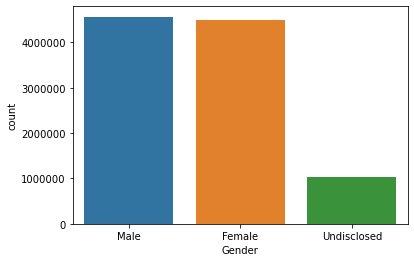

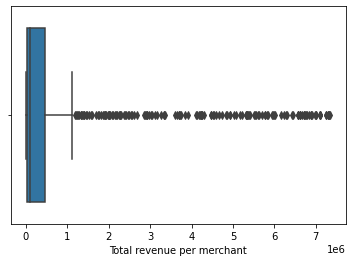

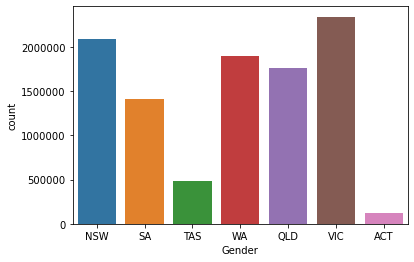

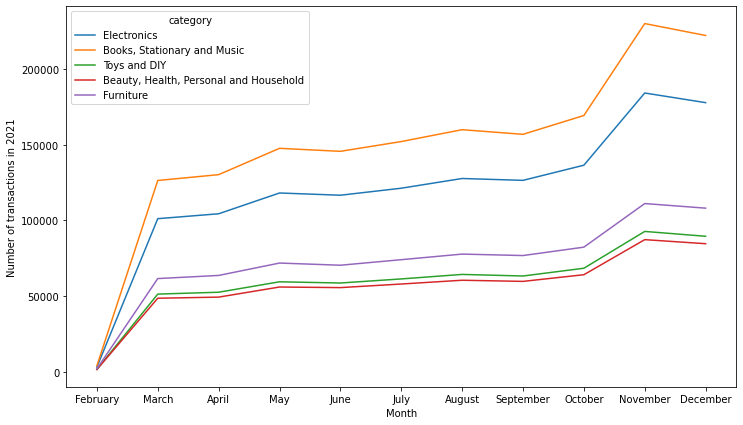

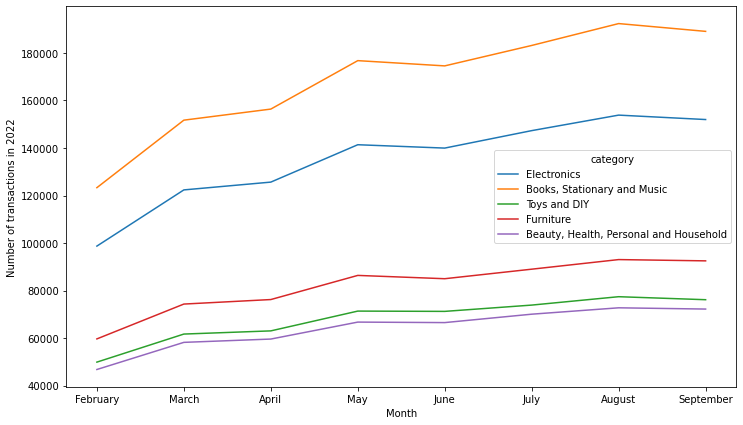

In [135]:
%run "../scripts/visualizations.py" '../scripts/paths.json'

In [138]:
num_transactions_by_postcode = outlier.internal4.groupBy('postcodes')
postcodes_data1 = spark.read.option("header", True).csv('../data/visualisations_postcodes.csv')
postcodes_data2 = postcodes_data1.withColumnRenamed('Postcode', 'postcodes')
postcodes_data = postcodes_data2.dropDuplicates(['postcodes'])
transactions_location = num_transactions_by_postcode.join(postcodes_data,['postcodes'], 'inner')



# conver transactions location to pandas df
transactions_location_pdf = transactions_location.toPandas()

aus_coords = [-25.2744, 133.7751]
m = folium.Map(aus_coords, tiles='OpenStreetMap', zoom_start=4.5)

for index, row in transactions_location_pdf.iterrows():
    if row['count'] >= 10000:
        marker_color = 'darkred'
        fill_color = 'darkred'
    elif row['count'] >= 5000:
        marker_color = 'red'
        fill_color = 'red'
    elif row['count'] >= 500:
        marker_color = 'darkorange'
        fill_color = 'darkorange'
    elif row['count'] >= 100:
        marker_color = 'orange'
        fill_color = 'orange'
    elif row['count'] <= 50 :
        marker_color = 'yellow'
        fill_color = 'yellow'
    else:
        marker_color='darkpurple'
        fill_color = 'darkpurple'
        
    folium.Circle(
          location=[row['Lat'], row['Lon']],
          popup= 'Number of transactions: ' +str(row['count']),
          tooltip=row['Suburb'],
          radius=row['count'],
          color=marker_color,
          fill=True,
          fill_color=fill_color,
       ).add_to(m)
m.save('../plots/bubble_plot_num_transactions_by_location.html')

m

AttributeError: 'GroupedData' object has no attribute 'join'

In [ ]:
transactions.createOrReplaceTempView("temp_view")

trans_2021 = spark.sql(""" 

SELECT Month, category, COUNT(merchant_abn) as transactions_2021
FROM temp_view
WHERE Year == '2021'
GROUP BY Month, category

""")

trans_2022 = spark.sql(""" 

SELECT Month, category, COUNT(merchant_abn) as transactions_2022
FROM temp_view
WHERE Year == '2022'
GROUP BY Month, category

""")


trans_2021_df = trans_2021.toPandas()
trans_2022_df = trans_2022.toPandas()


month_2021 = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 
'September', 'October', 'November','December']
month_2022 = ['Janaury', 'February', 'March', 'April', 'May', 'June', 'July', 
'August', 'September']



# Order the month column 


trans_2021_df['Month'] = pd.Categorical(trans_2021_df['Month'], 
categories = month_2021, ordered=True)
trans_2021_df.sort_values(by = "Month", inplace = True)

trans_2022_df['Month'] = pd.Categorical(trans_2022_df['Month'], 
categories = month_2022, ordered=True)
trans_2022_df.sort_values(by = "Month", inplace = True)



fig4, ax4 = plt.subplots(figsize=(12,7))
sns.lineplot(data=trans_2021_df, x="Month", y="transactions_2021", 
hue="category")
ax4.set_ylabel("Number of transactions in 2021")



fig5, ax5 = plt.subplots(figsize=(12,7))
sns.lineplot(data=trans_2022_df, x="Month", y="transactions_2022", 
hue="category")
ax5.set_ylabel("Number of transactions in 2022")b

# External datasets
## Check oultiers

### Census data

In [20]:
# summary statistics
census.describe()

,SA2_code,total_males,total_females,total_persons
count,2.472000e+03,2472.000000,2472.000000,2472.000000
mean,3.177555e+08,5074.887136,5209.415049,10284.254450
std,1.977886e+08,3019.275754,3161.883118,6171.395057
min,1.010210e+08,0.000000,0.000000,0.000000
25%,1.270315e+08,2669.750000,2678.000000,5384.750000
50%,3.030411e+08,4774.000000,4875.000000,9656.000000
75%,4.060111e+08,7169.000000,7511.500000,14675.000000
max,9.999995e+08,14327.000000,13783.000000,28116.000000


### Income data
Income data contains the total income for each SA2 region - not income per person

In [21]:
income.head()

,SA2_code,SA2_name,income_2018-2019
0,101021007,Braidwood,120763285
1,101021008,Karabar,338308979
2,101021009,Queanbeyan,441160946
3,101021010,Queanbeyan - East,237035656
4,101021011,Queanbeyan Region,1050285692


In [22]:
# summary statistics income_2018-2019
income['income_2018-2019'].describe()

count    2.244000e+03
mean     4.234613e+08
std      3.478390e+08
min     -7.968300e+04
25%      1.767428e+08
50%      3.324043e+08
75%      5.684244e+08
max      3.493429e+09
Name: income_2018-2019, dtype: float64

<AxesSubplot:>

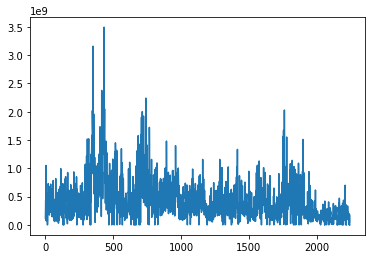

In [23]:
# income distribution
income['income_2018-2019'].astype(np.double).plot()

In [24]:
# Check which SA2 regions have negative sum of income for that region
income.loc[income['income_2018-2019'] < 0]

,SA2_code,SA2_name,income_2018-2019
278,114011275,Ettrema - Sassafras - Budawang,-79683


In [25]:
# Check if this SA2 region is in the final join
internal3.filter(internal3.SA2_code == 114011275).collect()

[]

This SA2 region with a negative total sum of income is not in the final join - so this outlier is already removed

### Population data

In [26]:
population.head()

,SA2_code,SA2_name,state_code,state_name,population_2020,population_2021
0,101021007,Braidwood,1,New South Wales,4273,4330
1,101021008,Karabar,1,New South Wales,8519,8546
2,101021009,Queanbeyan,1,New South Wales,11437,11370
3,101021010,Queanbeyan - East,1,New South Wales,5077,5093
4,101021012,Queanbeyan West - Jerrabomberra,1,New South Wales,12796,12743


In [27]:
# descriptive stats for 2020 in each SA2 region
population['population_2020'].describe()

count     2454.000000
mean     10454.477995
std       6229.349880
min          0.000000
25%       5449.500000
50%       9778.000000
75%      14832.750000
max      28250.000000
Name: population_2020, dtype: float64

In [28]:
# descriptive stats for 2021 in each SA2 region
population['population_2021'].describe()

count     2454.000000
mean     10467.839853
std       6222.168569
min          0.000000
25%       5529.750000
50%       9831.000000
75%      14911.000000
max      28573.000000
Name: population_2021, dtype: float64

# Tags to categories


In [29]:
merchants = tbl_merchants.toPandas()
merchants.head()

,merchant_name,merchant_abn,categories,take_rate,revenue_levels
0,Felis Limited,10023283211,"furniture, home furnishings and equipment shop...",0.18,e
1,Arcu Ac Orci Corporation,10142254217,"cable, satellite, and otHer pay television and...",4.22,b
2,Nunc Sed Company,10165489824,"jewelry, watch, clock, and silverware shops",4.40,b
3,Ultricies Dignissim Lacus Foundation,10187291046,"wAtch, clock, and jewelry repair shops",3.29,b
4,Enim Condimentum PC,10192359162,"music shops - musical instruments, pianos, and...",6.33,a


In [30]:
categories = merchants["categories"]
# Remove symbols from tag and making everything lowercase
categories = categories.str.replace('[^\w\s]', '', regex = True)
categories = categories.str.lower()
categories

0       furniture home furnishings and equipment shops...
1       cable satellite and other pay television and r...
2                jewelry watch clock and silverware shops
3                    watch clock and jewelry repair shops
4       music shops  musical instruments pianos and sh...
                              ...                        
4021               opticians optical goods and eyeglasses
4022                     books periodicals and newspapers
4023                                          shoe  shops
4024                 motor vehicle supplies and new parts
4025                 motor vehicle supplies and new parts
Name: categories, Length: 4026, dtype: object

In [31]:
merchants['cleaned_tags'] = categories

In [32]:
merchants.head()

,merchant_name,merchant_abn,categories,take_rate,revenue_levels,cleaned_tags
0,Felis Limited,10023283211,"furniture, home furnishings and equipment shop...",0.18,e,furniture home furnishings and equipment shops...
1,Arcu Ac Orci Corporation,10142254217,"cable, satellite, and otHer pay television and...",4.22,b,cable satellite and other pay television and r...
2,Nunc Sed Company,10165489824,"jewelry, watch, clock, and silverware shops",4.40,b,jewelry watch clock and silverware shops
3,Ultricies Dignissim Lacus Foundation,10187291046,"wAtch, clock, and jewelry repair shops",3.29,b,watch clock and jewelry repair shops
4,Enim Condimentum PC,10192359162,"music shops - musical instruments, pianos, and...",6.33,a,music shops musical instruments pianos and sh...


In [33]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(merchants['cleaned_tags'])

In [34]:
categories_label = {0 : 'Furniture' , 1 : 'Toys and DIY', 2 : 'Beauty, Health, Personal and Household', 3 : 'Books, Stationary and Music', 4 : 'Electronics' }
len(categories_label)

5

In [35]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=5,random_state=42)
LDA.fit(dtm)
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC: {categories_label[index].upper()}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC: FURNITURE
['new', 'motor', 'stock', 'nursery', 'flowers', 'florists', 'home', 'furnishings', 'appliances', 'manufacturers', 'shoe', 'furniture', 'equipment', 'supplies', 'shops']


THE TOP 15 WORDS FOR TOPIC: TOYS AND DIY
['galleries', 'dealers', 'art', 'telecom', 'service', 'bicycle', 'repair', 'sales', 'artist', 'craft', 'supply', 'watch', 'clock', 'jewelry', 'shops']


THE TOP 15 WORDS FOR TOPIC: BEAUTY, HEALTH, PERSONAL AND HOUSEHOLD
['nurseries', 'books', 'periodicals', 'newspapers', 'beauty', 'health', 'spas', 'data', 'design', 'systems', 'processing', 'integrated', 'programming', 'computer', 'services']


THE TOP 15 WORDS FOR TOPIC: BOOKS, STATIONARY AND MUSIC
['printing', 'stationery', 'writing', 'instruments', 'pianos', 'musical', 'sheet', 'tent', 'awning', 'digital', 'movies', 'books', 'shops', 'goods', 'music']


THE TOP 15 WORDS FOR TOPIC: ELECTRONICS
['television', 'radio', 'cable', 'satellite', 'pay', 'equipment', 'computer', 'software', 'perip

In [36]:
topic_results = LDA.transform(dtm)
merchants['store_type'] = topic_results.argmax(axis=1)
merchants.head(10)

,merchant_name,merchant_abn,categories,take_rate,revenue_levels,cleaned_tags,store_type
0,Felis Limited,10023283211,"furniture, home furnishings and equipment shop...",0.18,e,furniture home furnishings and equipment shops...,0
1,Arcu Ac Orci Corporation,10142254217,"cable, satellite, and otHer pay television and...",4.22,b,cable satellite and other pay television and r...,4
2,Nunc Sed Company,10165489824,"jewelry, watch, clock, and silverware shops",4.40,b,jewelry watch clock and silverware shops,1
3,Ultricies Dignissim Lacus Foundation,10187291046,"wAtch, clock, and jewelry repair shops",3.29,b,watch clock and jewelry repair shops,1
4,Enim Condimentum PC,10192359162,"music shops - musical instruments, pianos, and...",6.33,a,music shops musical instruments pianos and sh...,3
5,Fusce Company,10206519221,"gift, card, novelty, and souvenir shops",6.34,a,gift card novelty and souvenir shops,4
6,Aliquam Enim Incorporated,10255988167,"computers, comPUter peripheral equipment, and ...",4.32,b,computers computer peripheral equipment and so...,4
7,Ipsum Primis Ltd,10264435225,"watch, clock, and jewelry repair shops",2.39,c,watch clock and jewelry repair shops,1
8,Pede Ultrices Industries,10279061213,"computer programming , data processing, and in...",5.71,a,computer programming data processing and inte...,2
9,Nunc Inc.,10323485998,"furniture, home furnishings and equipment shop...",6.61,a,furniture home furnishings and equipment shops...,0


In [37]:
merchants['category'] = merchants['store_type'].map(categories_label)

In [38]:
merchants.head()

,merchant_name,merchant_abn,categories,take_rate,revenue_levels,cleaned_tags,store_type,category
0,Felis Limited,10023283211,"furniture, home furnishings and equipment shop...",0.18,e,furniture home furnishings and equipment shops...,0,Furniture
1,Arcu Ac Orci Corporation,10142254217,"cable, satellite, and otHer pay television and...",4.22,b,cable satellite and other pay television and r...,4,Electronics
2,Nunc Sed Company,10165489824,"jewelry, watch, clock, and silverware shops",4.40,b,jewelry watch clock and silverware shops,1,Toys and DIY
3,Ultricies Dignissim Lacus Foundation,10187291046,"wAtch, clock, and jewelry repair shops",3.29,b,watch clock and jewelry repair shops,1,Toys and DIY
4,Enim Condimentum PC,10192359162,"music shops - musical instruments, pianos, and...",6.33,a,music shops musical instruments pianos and sh...,3,"Books, Stationary and Music"


# Ranking models 

In [43]:
# take list of values as weights for fraud, transactions, revenue, customer, take rate
%run '../models/ranking_model.py' -10,1,4,2,3

Ranking for  Furniture category: 
Rank  1 :  Nullam Nisl Institute
Rank  2 :  Tristique Neque Venenatis Associates
Rank  3 :  Mi Associates
Rank  4 :  Nunc Nulla Corporation
Rank  5 :  Duis Foundation
Rank  6 :  Pede Cras LLP
Rank  7 :  Vitae Nibh Donec Institute
Rank  8 :  Morbi Sit Corporation
Rank  9 :  Blandit Mattis Company
Rank  10 :  Montes Nascetur Ridiculus Ltd


Ranking for  Electronics category: 
Rank  1 :  Sed Nec Corp.
Rank  2 :  Egestas Limited
Rank  3 :  Nulla Integer Vulputate PC
Rank  4 :  Euismod Corporation
Rank  5 :  Auctor Non Incorporated
Rank  6 :  Id Limited
Rank  7 :  Duis A LLP
Rank  8 :  Aliquet Molestie Tellus Company
Rank  9 :  Non Egestas LLP
Rank  10 :  Ipsum Leo Consulting


Ranking for  Toys and DIY category: 
Rank  1 :  Ipsum Company
Rank  2 :  Arcu Corporation
Rank  3 :  Pede Inc.
Rank  4 :  Fusce Mollis Duis Corp.
Rank  5 :  Duis At Inc.
Rank  6 :  Sapien Aenean Inc.
Rank  7 :  Libero At LLC
Rank  8 :  Et Magnis Corp.
Rank  9 :  Pellentesque Tincidun